MRI Pipeline


In [1]:

import os, re, math, json, warnings, itertools
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

warnings.filterwarnings("ignore")

# paths
PROJECT_ROOT = Path("/Users/madhurabn/Desktop/adni")
MRI_FILE  = PROJECT_ROOT / "data" / "raw" / "MRI_data ADNI.xlsx"
OUTDIR      = PROJECT_ROOT / "data" / "processed"
PLOTDIR  = OUTDIR / "plots" / "mri"



assert Path(MRI_FILE).exists(), f"Missing MRI file: {MRI_FILE}"
print("Working directory:", Path('.').resolve())
print("MRI file size:", Path(MRI_FILE).stat().st_size, "bytes")


Working directory: /Users/madhurabn/Desktop/adni
MRI file size: 12650126 bytes


In [2]:
# Load MRI & earliest-visit selection
mri = pd.read_excel(MRI_FILE)
print("MRI shape:", mri.shape)
if "PTID" not in mri.columns or "visit" not in mri.columns:
    raise KeyError("MRI must contain 'PTID' and 'visit'. Found: " + ", ".join(mri.columns[:20]))

visit_priority = ["bl","init","sc","m03","m06","m12","m24","m36","m48","m60","m72"]
def norm_visit(v):
    if pd.isna(v): return "zzz"
    s = str(v).strip().lower()
    s = s.replace("initial","init")
    return s
order_map = {v:i for i,v in enumerate(visit_priority)}
mri["visit_norm"]  = mri["visit"].map(norm_visit)
mri["visit_order"] = mri["visit_norm"].map(lambda v: order_map.get(v, 999))
mri_bl = (mri
          .sort_values(["PTID","visit_order"])
          .drop_duplicates("PTID", keep="first")
          .drop(columns=["visit_norm","visit_order"]))
print("After earliest-visit filter:", mri_bl.shape)


core_out    = OUTDIR / "mri_baseline.xlsx"
mri_bl.to_excel(core_out, index=False)
print("Saved:", core_out)

MRI shape: (5045, 338)
After earliest-visit filter: (1194, 338)


Saved: /Users/madhurabn/Desktop/adni/data/processed/mri_baseline.xlsx


In [3]:

#  Normalize key ROI column names (Hippocampus, Ventricles, Parahippocampal)
# This creates clean aliases: Hippocampus_L, Hippocampus_R, LateralVentricle_L, LateralVentricle_R, Parahippocampal_L, Parahippocampal_R

def first_match(cols, tokens):
    tokens = [t.lower() for t in tokens]
    for c in cols:
        name = c.lower()
        if all(t in name for t in tokens):
            return c
    return None

cols = list(mri_bl.columns)

ren_map = {}

# Hippocampus L/R
hipp_L = first_match(cols, ["hippocampus", "left"]) or first_match(cols, ["left", "hippocampus"])
hipp_R = first_match(cols, ["hippocampus", "right"]) or first_match(cols, ["right", "hippocampus"])
if hipp_L and "Hippocampus_L" not in mri_bl.columns:
    ren_map[hipp_L] = "Hippocampus_L"
if hipp_R and "Hippocampus_R" not in mri_bl.columns:
    ren_map[hipp_R] = "Hippocampus_R"

# Lateral Ventricle L/R
vent_L = first_match(cols, ["lateralventricle", "left"]) or first_match(cols, ["left", "lateralventricle"])
vent_R = first_match(cols, ["lateralventricle", "right"]) or first_match(cols, ["right", "lateralventricle"])
if vent_L and "LateralVentricle_L" not in mri_bl.columns:
    ren_map[vent_L] = "LateralVentricle_L"
if vent_R and "LateralVentricle_R" not in mri_bl.columns:
    ren_map[vent_R] = "LateralVentricle_R"

# Parahippocampal L/R
para_L = first_match(cols, ["parahippocamp", "left"]) or first_match(cols, ["left", "parahippocamp"])
para_R = first_match(cols, ["parahippocamp", "right"]) or first_match(cols, ["right", "parahippocamp"])
if para_L and "Parahippocampal_L" not in mri_bl.columns:
    ren_map[para_L] = "Parahippocampal_L"
if para_R and "Parahippocampal_R" not in mri_bl.columns:
    ren_map[para_R] = "Parahippocampal_R"

if ren_map:
    mri_bl = mri_bl.rename(columns=ren_map)
    print("ROI columns normalized:", ren_map)
else:
    print("No ROI columns needed normalization (Hipp/Vent/Parahipp).")


ROI columns normalized: {'Subcortical Volume (aseg.stats) of LeftHippocampus': 'Hippocampus_L', 'Subcortical Volume (aseg.stats) of RightHippocampus': 'Hippocampus_R', 'Subcortical Volume (aseg.stats) of LeftInferiorLateralVentricle': 'LateralVentricle_L', 'Subcortical Volume (aseg.stats) of RightInferiorLateralVentricle': 'LateralVentricle_R', 'Cortical Volume (aparc.stats) of LeftParahippocampal': 'Parahippocampal_L', 'Cortical Volume (aparc.stats) of RightParahippocampal': 'Parahippocampal_R'}


In [4]:
# Quick summary for baseline 
print("\n Baseline cohort statistics ")
print("Number of patients:", mri_bl["PTID"].nunique())
print("Visits included:", mri_bl["visit"].value_counts().to_dict())

# Overall shape
print("Rows:", mri_bl.shape[0], " | Columns:", mri_bl.shape[1])

# Missingness summary 
miss_pct = mri_bl.isna().mean().sort_values(ascending=False)
print("\nTop 10 features by missingness:")
print(miss_pct.head(10))

# Numeric summary (basic stats for first few numeric columns)
num_cols = [c for c in mri_bl.columns if np.issubdtype(mri_bl[c].dtype, np.number)]
if num_cols:
    print("\nDescriptive stats (first 5 numeric columns):")
    display(mri_bl[num_cols].describe().T.head(5))
else:
    print("\nNo numeric columns found at this stage.")



 Baseline cohort statistics 
Number of patients: 1194
Visits included: {'sc': 614, 'v02': 101, 'init': 97, '4_sc': 95, 'v04': 57, 'v05': 51, 'bl': 51, 'v11': 40, 'm03': 37, 'v21': 27, 'y2': 8, 'y1': 5, 'm06': 5, '4_m12': 3, 'y4': 1, '4_init': 1, 'scmri': 1}
Rows: 1194  | Columns: 338

Top 10 features by missingness:
Subcortical Volume (aseg.stats) of FifthVentricle    0.992462
VENTQC                                               0.917923
OVERALLQC                                            0.917923
TEMPQC                                               0.917923
FRONTQC                                              0.917923
PARQC                                                0.917923
INSULAQC                                             0.917923
OCCQC                                                0.917923
BGQC                                                 0.917923
CWMQC                                                0.917923
dtype: float64

Descriptive stats (first 5 numeric columns):


,count,mean,std,min,25%,50%,75%,max
RID,1194.0,4073.703518,2960.310647,3.000,1035.50000,4513.500,6327.75,10751.000
Subcortical Volume (aseg.stats) of RightPallidum,1193.0,1854.026655,253.915783,1129.100,1679.00000,1830.300,2011.60,2839.300
Cortical Volume (aparc.stats) of RightParacentral,1168.0,3531.589897,549.660597,2124.000,3142.50000,3505.000,3858.25,5609.000
Surface Area (aparc.stats) of RightParacentral,1168.0,1468.535959,198.398858,998.000,1326.75000,1457.500,1581.25,2571.000
Thickness Average (aparc.stats) of RightParacentral,1168.0,2.267424,0.188141,1.475,2.14075,2.285,2.40,2.781


In [5]:
# Quality control handlling 

def is_fail(x):
    s = str(x).strip().lower()
    return s in {"fail","0","false","f"}

mri_qc = mri_bl.copy()

# OVERALLQC drop
if "OVERALLQC" in mri_qc.columns:
    before = mri_qc.shape[0]
    mri_qc = mri_qc[~mri_qc["OVERALLQC"].map(is_fail)].copy()
    print(f"Dropped {before - mri_qc.shape[0]} rows due to OVERALLQC=Fail")
else:
    print("OVERALLQC not found; skipping row drop.")

# Partial QC families (token-based match on headers)
qc_family = {
    "TEMPQC":  ["TemporalPole","Fusiform","SuperiorTemporal","MiddleTemporal","InferiorTemporal"],
    "FRONTQC": ["FrontalPole","Precentral","SuperiorFrontal","CaudalMiddleFrontal","RostralMiddleFrontal","MedialOrbitofrontal"],
    "PARQC":   ["SuperiorParietal","InferiorParietal","Supramarginal","Precuneus","Postcentral","Paracentral"],
    "INSULAQC":["Insula"],
    "OCCQC":   ["LateralOccipital","Cuneus","Lingual","Pericalcarine"],
    "BGQC":    ["Caudate","Putamen","Pallidum","Thalamus","Accumbens","Amygdala","Hippocampus"],
    "CWMQC":   ["WhiteMatter"],
    "VENTQC":  ["LateralVentricle","InferiorLateralVentricle","ThirdVentricle"],
    "HIPPOQC": ["Hippocampus"]
}

for qc, tokens in qc_family.items():
    if qc in mri_qc.columns:
        mask = mri_qc[qc].map(is_fail)
        if mask.any():
            affected_cols = [c for c in mri_qc.columns if any(t in c for t in tokens)]
            if affected_cols:
                mri_qc.loc[mask, affected_cols] = np.nan
                print(f"{qc}: set NaN in {len(affected_cols)} ROI cols for {mask.sum()} rows")
            else:
                print(f"{qc}: no matching ROI columns found for tokens={tokens}")
print("QC handling complete. Shape:", mri_qc.shape)


Dropped 1 rows due to OVERALLQC=Fail
TEMPQC: set NaN in 40 ROI cols for 15 rows
FRONTQC: set NaN in 48 ROI cols for 16 rows
PARQC: set NaN in 48 ROI cols for 25 rows
INSULAQC: set NaN in 8 ROI cols for 1 rows
OCCQC: set NaN in 32 ROI cols for 50 rows
VENTQC: set NaN in 5 ROI cols for 2 rows
HIPPOQC: set NaN in 2 ROI cols for 16 rows
QC handling complete. Shape: (1193, 338)


In [6]:
# unsupervised filtering on all MRI features

MUST_KEEP_TOKEN_GROUPS = [
    # Subcortical volumes (L/R)
    ["Hippocampus"], ["Amygdala"], ["Thalamus"], ["Caudate"], ["Putamen"],
    ["LateralVentricle"], ["InferiorLateralVentricle"],
    # AD-signature cortical means (aparc thickness/volume if present)
    ["Entorhinal"], ["Parahippocampal"], ["Precuneus"], ["PosteriorCingulate"],
    # Global measures
    ["EstimatedTotalIntraCranialVol","eTIV","ICV"], ["MeanThickness"], ["TotalCorticalGrayMatter","Cortical Gray Matter"],
    # White matter hypointensities / if present
    ["WhiteMatterHypointensities","WM-hypointensities","White Matter Hypointensities"],
]

all_cols = list(mri_qc.columns)
def match_any_token_group(colname: str, groups) -> bool:
    return any(all(tok in colname for tok in group) for group in groups)

must_keep_cols = ["PTID","visit"]
for c in all_cols:
    if match_any_token_group(c, MUST_KEEP_TOKEN_GROUPS):
        must_keep_cols.append(c)
must_keep_cols = list(dict.fromkeys(must_keep_cols))  

print(f"Matched must-keep columns: {len(must_keep_cols)}")
print(must_keep_cols[:10], '...')
mri_core = mri_qc[must_keep_cols].copy()
print("mri_core shape (IDs + must-keep):", mri_core.shape)


Matched must-keep columns: 48
['PTID', 'visit', 'Parahippocampal_R', 'Surface Area (aparc.stats) of RightParahippocampal', 'Thickness Average (aparc.stats) of RightParahippocampal', 'Thickness Stardard Deviation (aparc.stats) of RightParahippocampal', 'Cortical Volume (aparc.stats) of RightPosteriorCingulate', 'Surface Area (aparc.stats) of RightPosteriorCingulate', 'Thickness Average (aparc.stats) of RightPosteriorCingulate', 'Thickness Stardard Deviation (aparc.stats) of RightPosteriorCingulate'] ...
mri_core shape (IDs + must-keep): (1193, 48)


In [7]:

# configuration
TARGET_FEATURES = 200     # total features to aim for 
MAX_MISS   = 0.30         # drop cols with >30% missingness
NZV_THRESH = 0.98         # near-zero variance for categoricals
REDUND_R   = 0.90         # redundancy threshold (Spearman)
VAR_DROP_Q = 0.20         # drop bottom 20% variance among numerics
ENTROPY_Q  = 0.05         # drop bottom 5% entropy among categoricals


df_all = mri_qc.copy()
protected = set([c for c in must_keep_cols if c in df_all.columns] + ["PTID","visit"])

# Stricter missingness
miss = df_all.isna().mean()
pass_miss = miss.index[miss <= MAX_MISS].tolist()
drop_miss = [c for c in df_all.columns if c not in pass_miss and c not in protected]
df1 = df_all[[c for c in df_all.columns if c in pass_miss or c in protected]].copy()
print(f"[Missingness] kept={len(df1.columns)} (incl. protected), dropped={len(drop_miss)} > {MAX_MISS*100:.0f}%")

#  Low-information filters
num_cols = [c for c in df1.columns if c not in ["PTID","visit"] and np.issubdtype(df1[c].dtype, np.number)]
cat_cols = [c for c in df1.columns if c not in ["PTID","visit"] and c not in num_cols]

keep_cols = set(df1.columns)

#  Near-constant numerics
for c in num_cols:
    if c in protected: 
        continue
    s = df1[c]
    if s.nunique(dropna=True) <= 1 or float(np.nanstd(s.values)) == 0.0:
        keep_cols.discard(c)

#  Near-constant categoricals 
for c in cat_cols:
    if c in protected: 
        continue
    vc = df1[c].astype(str).value_counts(dropna=False)
    if not vc.empty and (vc.iloc[0] / max(1, vc.sum())) >= NZV_THRESH:
        keep_cols.discard(c)

#  Drop bottom 20% variance among numerics
remaining_num = [c for c in num_cols if c in keep_cols and c not in protected]
if remaining_num:
    variances = pd.Series({c: np.nanvar(df1[c].values) for c in remaining_num})
    thresh_var = variances.quantile(VAR_DROP_Q)
    low_var = variances[variances <= thresh_var].index.tolist()
    for c in low_var:
        keep_cols.discard(c)

#  Drop bottom 5% categorical entropy 
def shannon_entropy(series):
    vc = series.astype(str).value_counts(normalize=True, dropna=False)
    p = vc.values
    return float(-(p * np.log(p + 1e-12)).sum())

remaining_cat = [c for c in cat_cols if c in keep_cols and c not in protected]
if remaining_cat:
    ent = pd.Series({c: shannon_entropy(df1[c]) for c in remaining_cat})
    thresh_ent = ent.quantile(ENTROPY_Q)
    low_ent = ent[ent <= thresh_ent].index.tolist()
    for c in low_ent:
        keep_cols.discard(c)

df2 = df1[list(keep_cols)].copy()
print(f"[Low-info] kept={len(df2.columns)} after NZV/variance/entropy (protected preserved)")

# Exact duplicate columns
def deduplicate_columns(df):
    seen = {}
    keep = []
    dupes = []
    for c in df.columns:
        key = tuple(pd.util.hash_pandas_object(df[c], index=False).values)
        if key in seen:
            dupes.append(c)
        else:
            seen[key] = c
            keep.append(c)
    return df[keep].copy(), dupes

df3, dup_cols = deduplicate_columns(df2)
print(f"[Duplicates] dropped={len(dup_cols)}")

# Redundancy pruning on numerics (Spearman) |r| >= REDUND_R
num_cols3 = [c for c in df3.columns if c not in ["PTID","visit"] and np.issubdtype(df3[c].dtype, np.number)]
to_drop = set()
if len(num_cols3) > 1:
    corr = df3[num_cols3].corr(method="spearman")
    for i, c1 in enumerate(num_cols3):
        if c1 in to_drop: 
            continue
        for c2 in num_cols3[i+1:]:
            if c2 in to_drop:
                continue
            r = corr.loc[c1, c2]
            if pd.notna(r) and abs(r) >= REDUND_R:
                if c1 in protected and c2 not in protected:
                    to_drop.add(c2)
                elif c2 in protected and c1 not in protected:
                    to_drop.add(c1)
                elif (c1 not in protected) and (c2 not in protected):
                    # prefer dropping higher missingness
                    miss1 = miss.get(c1, 0.0); miss2 = miss.get(c2, 0.0)
                    drop_c = c1 if miss1 >= miss2 else c2
                    to_drop.add(drop_c)

df4 = df3[[c for c in df3.columns if c not in to_drop]].copy()
print(f"[Redundancy] pruned={len(to_drop)} at |r|>={REDUND_R}. Remaining cols={len(df4.columns)}")

#  further reduction 
work_cols = [c for c in df4.columns if c not in ["PTID","visit"]]
prot_work = [c for c in work_cols if c in protected]
free_work = [c for c in work_cols if c not in protected]

target_allow = max(TARGET_FEATURES - len(prot_work), 0)

if len(free_work) > target_allow and len(work_cols) >= 3:
    
    numerics = [c for c in free_work if np.issubdtype(df4[c].dtype, np.number)]
    if len(numerics) >= 3:
        corr_all = df4[numerics].corr(method="spearman").abs().fillna(0.0)
        mean_r = corr_all.replace(1.0, np.nan).mean(skipna=True)  
       
        miss_sub = miss[numerics].fillna(0.0)
        miss_norm = (miss_sub - miss_sub.min()) / max(1e-12, (miss_sub.max() - miss_sub.min()))
        score = mean_r.add(miss_norm, fill_value=0.0).sort_values(ascending=False)

        drop_list = []
        for c in score.index:
            if len(free_work) - len(drop_list) <= target_allow:
                break
            if c in protected:
                continue
            drop_list.append(c)

        keep_set = set(df4.columns) - set(drop_list)
        df_filtered = df4[list(keep_set)].copy()
        print(f"[Target prune] Dropped {len(drop_list)} to hit target≈{TARGET_FEATURES}. Final cols={len(df_filtered.columns)}")
    else:
        df_filtered = df4.copy()
        print("[Target prune] Not enough numeric features to compute scores; skipping greedy prune.")
else:
    df_filtered = df4.copy()
    print("[Target prune] Within target already or no free features to prune.")

# Always ensure IDs present
if "PTID" not in df_filtered.columns: df_filtered.insert(0, "PTID", mri_qc["PTID"].values)
if "visit" not in df_filtered.columns: df_filtered.insert(1, "visit", mri_qc["visit"].values)

print("Filtered feature set size (pre-imputation):", len(df_filtered.columns))


[Missingness] kept=326 (incl. protected), dropped=12 > 30%
[Low-info] kept=270 after NZV/variance/entropy (protected preserved)
[Duplicates] dropped=0


[Redundancy] pruned=8 at |r|>=0.9. Remaining cols=262


[Target prune] Dropped 60 to hit target≈200. Final cols=202
Filtered feature set size (pre-imputation): 202


In [8]:
# Imputation + IQR clipping

id_cols = ["PTID","visit"]
feat_cols = [c for c in df_filtered.columns if c not in id_cols]

num_cols_f = [c for c in feat_cols if np.issubdtype(df_filtered[c].dtype, np.number)]
cat_cols_f = [c for c in feat_cols if c not in num_cols_f]

df_preimp = df_filtered.copy()

# Mode impute categoricals
if cat_cols_f:
    mode_imp = SimpleImputer(strategy="most_frequent")
    df_preimp[cat_cols_f] = mode_imp.fit_transform(df_preimp[cat_cols_f])

# MICE for numerics
df_imp = df_preimp.copy()
if num_cols_f:
    mice = IterativeImputer(random_state=42, max_iter=10, initial_strategy="median")
    df_imp[num_cols_f] = mice.fit_transform(df_imp[num_cols_f])

# IQR clipping 
def iqr_bounds(a, k=1.5):
    q1 = np.nanpercentile(a, 25); q3 = np.nanpercentile(a, 75); iqr = q3 - q1
    return q1 - k*iqr, q3 + k*iqr

volume_like_tokens = ["volume","surface area","thickness","ventricle","hippocampus","amygdala","putamen","caudate","thalamus","pallidum","icv"]
for c in num_cols_f:
    arr = df_imp[c].values
    lo, hi = iqr_bounds(arr)
    arr = np.clip(arr, lo, hi)
    if any(tok in c.lower() for tok in volume_like_tokens):
        arr = np.maximum(arr, 0)
    df_imp[c] = arr

print("Imputation complete. Shape:", df_imp.shape)


Imputation complete. Shape: (1193, 202)


Final feature count (excluding meta): 199
  1. Thickness Average (aparc.stats) of RightTemporalPole
  2. LateralVentricle_R
  3. Surface Area (aparc.stats) of LeftRostralAnteriorCingulate
  4. Cortical Volume (aparc.stats) of LeftParsTriangularis
  5. Surface Area (aparc.stats) of LeftRostralMiddleFrontal
  6. Cortical Volume (aparc.stats) of RightLateralOrbitofrontal
  7. Thickness Average (aparc.stats) of RightBankssts
  8. Cortical Volume (aparc.stats) of RightEntorhinal
  9. Surface Area (aparc.stats) of RightCaudalAnteriorCingulate
 10. Thickness Average (aparc.stats) of LeftParsOrbitalis
 11. Cortical Volume (aparc.stats) of LeftLateralOrbitofrontal
 12. Cortical Volume (aparc.stats) of LeftCaudalAnteriorCingulate
 13. Surface Area (aparc.stats) of RightParahippocampal
 14. Cortical Volume (aparc.stats) of Icv
 15. Cortical Volume (aparc.stats) of LeftTransverseTemporal
 16. Thickness Average (aparc.stats) of LeftSuperiorTemporal
 17. Hippocampus_R
 18. Thickness Stardard Deviati

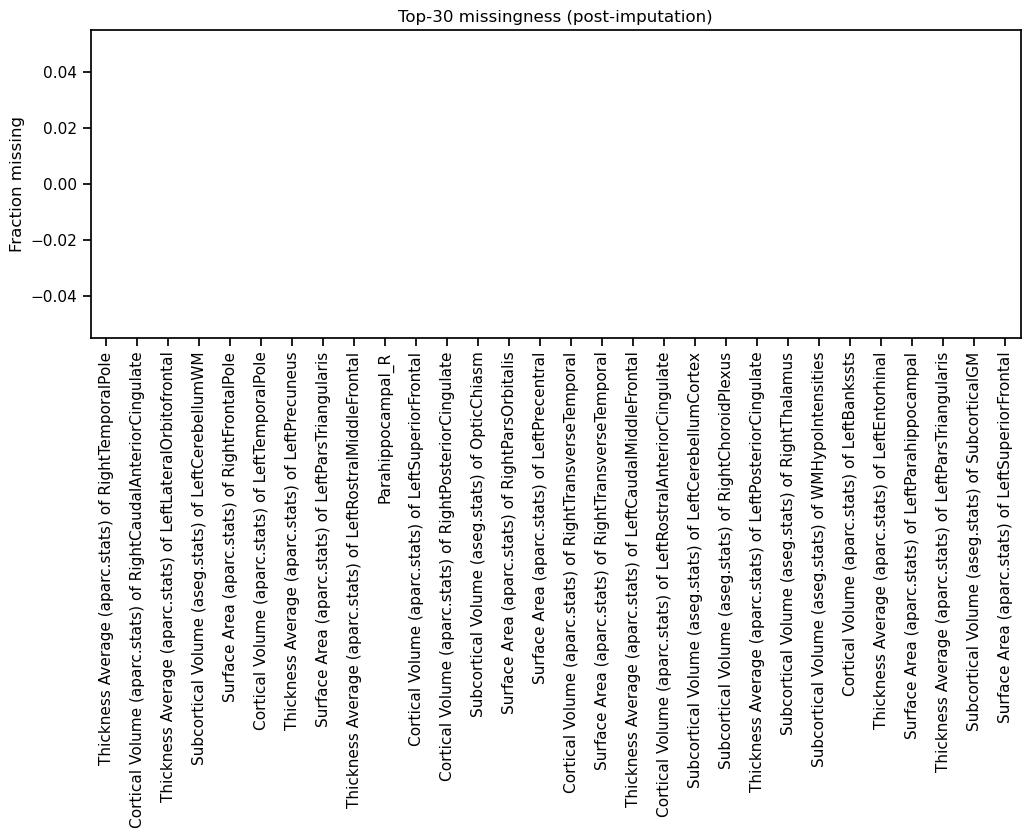

In [9]:
#  Post-imputation MRI EDA
import numpy as np, pandas as pd, matplotlib.pyplot as plt, re
from pathlib import Path

try:
    import seaborn as sns
    _HAS_SNS = True
    sns.set_context("notebook")
except Exception:
    _HAS_SNS = False


def _safe(name: str) -> str:
    return re.sub(r'[\\/*?:"<>| ]+', "_", str(name))

PLOTDIR = PLOTDIR if 'PLOTDIR' in globals() else Path("./data/processed/plots/mri_post")
PLOTDIR.mkdir(parents=True, exist_ok=True)

# Save + display the final feature names 
meta_cols = [c for c in df_imp.columns if c.lower() in {"ptid","rid","subject","id","visit","viscode"}]
final_features = [c for c in df_imp.columns if c not in meta_cols]
print(f"Final feature count (excluding meta): {len(final_features)}")
for i, c in enumerate(final_features, 1):
    print(f"{i:>3}. {c}")
pd.Series(final_features).to_csv(PLOTDIR / "mri_final_feature_list.csv", index=False)

# Top-30 missingness (post imputation) 
miss_post = df_imp[final_features].isna().mean().sort_values(ascending=False)
plt.figure(figsize=(12,4))
miss_post.head(30).plot(kind="bar")
plt.title("Top-30 missingness (post-imputation)")
plt.ylabel("Fraction missing")
plt.tight_layout(); plt.savefig(PLOTDIR / "post_missingness_top30.png", dpi=150); plt.show()

In [10]:
# Oredreing columns before explorting to excel

meta = ["PTID", "visit"]
pruned_order = [c for c in df_filtered.columns if c not in meta]

# Build an ordered list of columns
export_cols, seen = [], set()
for c in (meta + pruned_order):
    if c in df_imp.columns and c not in seen:
        export_cols.append(c); seen.add(c)

df_final = df_imp[export_cols].copy()
print("Final export shape:", df_final.shape)


Final export shape: (1193, 202)


In [11]:
imputed_out = OUTDIR / "mri_imputed.xlsx"

df_final.to_excel(imputed_out, index=False)

print("Saved:", imputed_out)

Saved: /Users/madhurabn/Desktop/adni/data/processed/mri_imputed.xlsx


In [12]:

from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import f_classif, SelectKBest, SelectPercentile

# path 
CLINICAL_IMPUTED_FPATH = Path("/Users/madhurabn/Desktop/adni/data/processed/clinical_cognitive_demographic__imputed.xlsx")  # change if needed

# Selection  
USE_K_BEST = True
TOP_K = 100            
TOP_PERCENTILE = 30    

# diagnosis column names 
DIAG_CANDIDATES = [
    "DX", "DX_bl", "Diagnosis", "diagnosis", "Clinical_Diagnosis",
    "DXCHANGE", "Group", "Diag", "diagnosis_bl", "DXCURREN"
]

In [13]:

def _normalize_ptid_col(df):
    for c in df.columns:
        if str(c).strip().lower() in ["ptid", "subjectid", "participant_id", "rid", "subject"]:
            if c != "PTID":
                df = df.rename(columns={c: "PTID"})
            return df
    raise ValueError("No PTID column found. Expected a PTID/SubjectID/participant_id/RID/subject column.")

def _find_diagnosis_column(df, candidates):
    cols_lower = {str(c).lower(): c for c in df.columns}
    for cand in candidates:
        key = cand.lower()
        if key in cols_lower:
            return cols_lower[key]
    for c in df.columns:
        cl = str(c).lower()
        if "diagnos" in cl or cl in ["dx", "dx_bl", "dxcurren"]:
            return c
    return None


In [14]:

mri_df = df_final.copy()
mri_df = _normalize_ptid_col(mri_df.copy())

#  Load clinical/cognitive/demographic imputed Excel
assert CLINICAL_IMPUTED_FPATH.exists(), f"Clinical imputed file not found: {CLINICAL_IMPUTED_FPATH}"
if CLINICAL_IMPUTED_FPATH.suffix.lower() in [".xls",".xlsx"]:
    clin_df = pd.read_excel(CLINICAL_IMPUTED_FPATH)
else:
    clin_df = pd.read_csv(CLINICAL_IMPUTED_FPATH)
clin_df = _normalize_ptid_col(clin_df)

print("MRI df shape:", mri_df.shape)
print("Clinical df shape:", clin_df.shape)

#  Detect diagnosis column IN CLINICAL and subset to PTID and diagnosis ONLY
diag_col_clin = _find_diagnosis_column(clin_df, DIAG_CANDIDATES)
if diag_col_clin is None:
    raise ValueError("Could not auto-detect a diagnosis label column in the clinical table. "
                     "Add its name to DIAG_CANDIDATES or rename it to 'Diagnosis'.")
print("Detected diagnosis column in clinical table:", diag_col_clin)

clin_slim = clin_df[["PTID", diag_col_clin]].copy()
clin_slim = clin_slim.rename(columns={diag_col_clin: "Diagnosis"}) 

#  Merge clinical (PTID + Diagnosis) with MRI by PTID ONLY 
merged = mri_df.merge(clin_slim, on="PTID", how="left")
print("Merged shape (MRI + Diagnosis):", merged.shape)



MRI df shape: (1193, 202)
Clinical df shape: (1205, 17)
Detected diagnosis column in clinical table: DIAGNOSIS
Merged shape (MRI + Diagnosis): (1193, 203)


In [15]:

# Drop rows without diagnosis
before = merged.shape[0]
merged = merged.dropna(subset=["Diagnosis"])
after = merged.shape[0]
print("After dropping shape:", merged.shape)

After dropping shape: (1171, 203)


In [16]:
# Anova feature selection method on MRI

# Identify MRI numeric columns from ORIGINAL MRI table columns
mri_feature_cols = [c for c in mri_df.columns if c != "PTID" and hasattr(mri_df[c], "dtype") and np.issubdtype(mri_df[c].dtype, np.number)]
print(f"Detected {len(mri_feature_cols)} MRI numeric features.")

missing = [c for c in mri_feature_cols if c not in merged.columns]
if missing:
    print("Warning: some MRI columns missing after merge (first 10):", missing[:10])

work = merged[["PTID", "Diagnosis"] + [c for c in mri_feature_cols if c in merged.columns]].copy()

# Encode labels and run ANOVA
le = LabelEncoder()
y = le.fit_transform(work["Diagnosis"].astype(str).values)
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)

X = work[[c for c in mri_feature_cols if c in work.columns]].copy()
X = X.replace([np.inf,-np.inf], np.nan).fillna(0.0)

if USE_K_BEST:
    selector = SelectKBest(score_func=f_classif, k=min(TOP_K, X.shape[1]))
else:
    selector = SelectPercentile(score_func=f_classif, percentile=TOP_PERCENTILE)

selector.fit(X.values, y)
mask = selector.get_support()
scores = selector.scores_

selected_cols = [col for col, keep in zip(X.columns.tolist(), mask) if keep]
print(f"Selected {len(selected_cols)} MRI features via ANOVA.")

rank_df = pd.DataFrame({"feature": X.columns, "anova_f": scores}).sort_values("anova_f", ascending=False)


mri_selected_table = work[["PTID", "Diagnosis"] + selected_cols].copy()


MRI_SELECTED_FEATURES = selected_cols
df_mri_selected = mri_selected_table


#  export the final MRI dataset as Excel 
excel_out = OUTDIR / "mri_final.xlsx"
mri_selected_table.to_excel(excel_out, index=False)
print("Excel exported ->", excel_out)


Detected 200 MRI numeric features.
Label mapping: {'CN': np.int64(0), 'DEMENTIA': np.int64(1), 'MCI': np.int64(2)}
Selected 100 MRI features via ANOVA.


Excel exported -> /Users/madhurabn/Desktop/adni/data/processed/mri_final.xlsx


Saved bar chart -> /Users/madhurabn/Desktop/adni/data/processed/plots/mri/anova_selected_features_bar.png


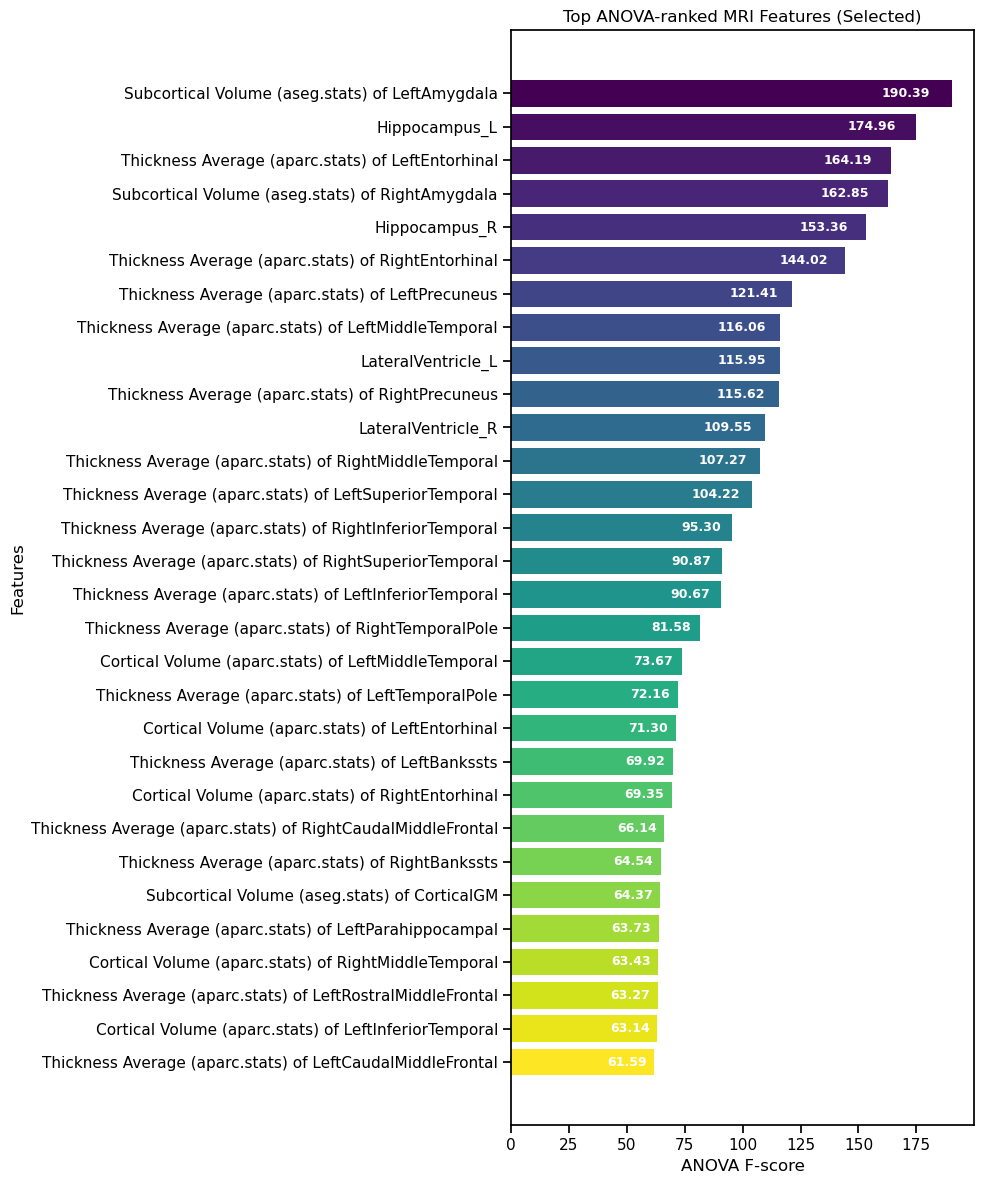

In [17]:
#  Plot ANOVA ranking for selected features (Top-N) as a colored bar chart
import matplotlib.pyplot as plt
import numpy as np

# Subset selected features with scores
rank_sel = rank_df[rank_df['feature'].isin(selected_cols)].copy().sort_values('anova_f', ascending=False)

TOP_N_PLOT = min(30, len(rank_sel))  
plot_df = rank_sel.head(TOP_N_PLOT)


colors = plt.cm.viridis(np.linspace(0, 1, TOP_N_PLOT))

plt.figure(figsize=(10, max(5, int(0.4 * TOP_N_PLOT))))
bars = plt.barh(plot_df['feature'][::-1], plot_df['anova_f'][::-1], color=colors[::-1])

# Add value labels 
for bar, val in zip(bars, plot_df['anova_f'][::-1]):
    plt.text(bar.get_width() - (0.05 * bar.get_width()), 
             bar.get_y() + bar.get_height() / 2,
             f"{val:.2f}", 
             va='center', ha='right', color='white', fontsize=9, fontweight='bold')

plt.xlabel('ANOVA F-score')
plt.ylabel('Features')
plt.title('Top ANOVA-ranked MRI Features (Selected)')

plt.tight_layout()
png_out = PLOTDIR / "anova_selected_features_bar.png"
plt.savefig(png_out, dpi=200, bbox_inches='tight')
print("Saved bar chart ->", png_out)

plt.show()
